<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[10:03:48] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


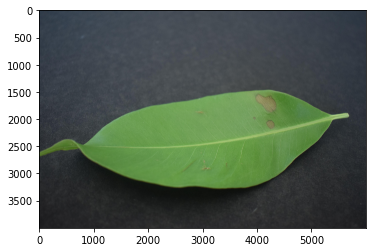

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

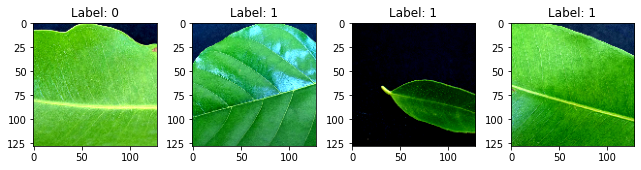

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[10:03:56] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[10:03:58] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2601957022599328 samples/sec                   batch loss = 0.8362995386123657 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.2615827324280413 samples/sec                   batch loss = 0.914862871170044 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.2671903292046638 samples/sec                   batch loss = 1.4396271705627441 | accuracy = 0.4666666666666667


Epoch[1] Batch[20] Speed: 1.265629573392444 samples/sec                   batch loss = 0.7043807506561279 | accuracy = 0.4875


Epoch[1] Batch[25] Speed: 1.262935455698011 samples/sec                   batch loss = 0.6533560752868652 | accuracy = 0.51


Epoch[1] Batch[30] Speed: 1.2648715678445546 samples/sec                   batch loss = 1.2911317348480225 | accuracy = 0.48333333333333334


Epoch[1] Batch[35] Speed: 1.2707996170910463 samples/sec                   batch loss = 0.6055300235748291 | accuracy = 0.4928571428571429


Epoch[1] Batch[40] Speed: 1.263965139511266 samples/sec                   batch loss = 0.5557177066802979 | accuracy = 0.5125


Epoch[1] Batch[45] Speed: 1.261601421349372 samples/sec                   batch loss = 0.3442018926143646 | accuracy = 0.5333333333333333


Epoch[1] Batch[50] Speed: 1.2640666573541182 samples/sec                   batch loss = 0.5235591530799866 | accuracy = 0.565


Epoch[1] Batch[55] Speed: 1.2612455731617134 samples/sec                   batch loss = 0.4001729190349579 | accuracy = 0.5590909090909091


Epoch[1] Batch[60] Speed: 1.267191190608117 samples/sec                   batch loss = 0.30547717213630676 | accuracy = 0.5791666666666667


Epoch[1] Batch[65] Speed: 1.2520361837306049 samples/sec                   batch loss = 1.657563328742981 | accuracy = 0.5846153846153846


Epoch[1] Batch[70] Speed: 1.250826517508811 samples/sec                   batch loss = 0.6340384483337402 | accuracy = 0.575


Epoch[1] Batch[75] Speed: 1.2549335937964576 samples/sec                   batch loss = 1.0131151676177979 | accuracy = 0.5833333333333334


Epoch[1] Batch[80] Speed: 1.2566869762404802 samples/sec                   batch loss = 0.2655734121799469 | accuracy = 0.6


Epoch[1] Batch[85] Speed: 1.255085210338711 samples/sec                   batch loss = 0.5205342769622803 | accuracy = 0.6058823529411764


Epoch[1] Batch[90] Speed: 1.265559975357465 samples/sec                   batch loss = 0.4904539883136749 | accuracy = 0.6055555555555555


Epoch[1] Batch[95] Speed: 1.2727729699486976 samples/sec                   batch loss = 0.3172834515571594 | accuracy = 0.6131578947368421


Epoch[1] Batch[100] Speed: 1.2702239697724356 samples/sec                   batch loss = 1.24397611618042 | accuracy = 0.615


Epoch[1] Batch[105] Speed: 1.2646185291176608 samples/sec                   batch loss = 0.7469821572303772 | accuracy = 0.6190476190476191


Epoch[1] Batch[110] Speed: 1.2685029340321188 samples/sec                   batch loss = 0.32793286442756653 | accuracy = 0.6227272727272727


Epoch[1] Batch[115] Speed: 1.2664109521208922 samples/sec                   batch loss = 0.4477222263813019 | accuracy = 0.6217391304347826


Epoch[1] Batch[120] Speed: 1.2629518079091366 samples/sec                   batch loss = 0.18528316915035248 | accuracy = 0.6229166666666667


Epoch[1] Batch[125] Speed: 1.2665388694544155 samples/sec                   batch loss = 0.5681442618370056 | accuracy = 0.626


Epoch[1] Batch[130] Speed: 1.26415714197017 samples/sec                   batch loss = 0.852868914604187 | accuracy = 0.6288461538461538


Epoch[1] Batch[135] Speed: 1.274778516068104 samples/sec                   batch loss = 0.41017624735832214 | accuracy = 0.6314814814814815


Epoch[1] Batch[140] Speed: 1.270154346333176 samples/sec                   batch loss = 0.35155490040779114 | accuracy = 0.6357142857142857


Epoch[1] Batch[145] Speed: 1.2703831514697925 samples/sec                   batch loss = 0.6357966065406799 | accuracy = 0.6344827586206897


Epoch[1] Batch[150] Speed: 1.2616051212522494 samples/sec                   batch loss = 0.6995380520820618 | accuracy = 0.6316666666666667


Epoch[1] Batch[155] Speed: 1.266423857406299 samples/sec                   batch loss = 0.644002377986908 | accuracy = 0.632258064516129


Epoch[1] Batch[160] Speed: 1.2651668759037866 samples/sec                   batch loss = 0.2514588534832001 | accuracy = 0.6375


Epoch[1] Batch[165] Speed: 1.2681650378724973 samples/sec                   batch loss = 0.7779415845870972 | accuracy = 0.6439393939393939


Epoch[1] Batch[170] Speed: 1.2709306369578113 samples/sec                   batch loss = 0.5515912771224976 | accuracy = 0.6411764705882353


Epoch[1] Batch[175] Speed: 1.268077524894497 samples/sec                   batch loss = 0.8704917430877686 | accuracy = 0.6428571428571429


Epoch[1] Batch[180] Speed: 1.2646487473339412 samples/sec                   batch loss = 0.9003407955169678 | accuracy = 0.6416666666666667


Epoch[1] Batch[185] Speed: 1.2679510214594376 samples/sec                   batch loss = 0.2629639506340027 | accuracy = 0.6472972972972973


Epoch[1] Batch[190] Speed: 1.2630679968573146 samples/sec                   batch loss = 0.771401047706604 | accuracy = 0.6513157894736842


Epoch[1] Batch[195] Speed: 1.267276283898562 samples/sec                   batch loss = 0.8135170936584473 | accuracy = 0.6512820512820513


Epoch[1] Batch[200] Speed: 1.2721102609760084 samples/sec                   batch loss = 1.0222200155258179 | accuracy = 0.65125


Epoch[1] Batch[205] Speed: 1.268017720124876 samples/sec                   batch loss = 0.41225260496139526 | accuracy = 0.6560975609756098


Epoch[1] Batch[210] Speed: 1.2693857264531299 samples/sec                   batch loss = 0.5204663872718811 | accuracy = 0.6607142857142857


Epoch[1] Batch[215] Speed: 1.2685739112669039 samples/sec                   batch loss = 0.5738855600357056 | accuracy = 0.6616279069767442


Epoch[1] Batch[220] Speed: 1.2664740471277482 samples/sec                   batch loss = 0.8430829644203186 | accuracy = 0.6625


Epoch[1] Batch[225] Speed: 1.2637744329151714 samples/sec                   batch loss = 0.6819221377372742 | accuracy = 0.6611111111111111


Epoch[1] Batch[230] Speed: 1.2654919122553285 samples/sec                   batch loss = 0.4628104865550995 | accuracy = 0.6663043478260869


Epoch[1] Batch[235] Speed: 1.2611713369822664 samples/sec                   batch loss = 1.1001132726669312 | accuracy = 0.6659574468085107


Epoch[1] Batch[240] Speed: 1.266978363849571 samples/sec                   batch loss = 0.37854379415512085 | accuracy = 0.6666666666666666


Epoch[1] Batch[245] Speed: 1.2638291730534028 samples/sec                   batch loss = 0.8757085800170898 | accuracy = 0.6653061224489796


Epoch[1] Batch[250] Speed: 1.264580019666804 samples/sec                   batch loss = 0.7691696286201477 | accuracy = 0.664


Epoch[1] Batch[255] Speed: 1.2621556998757721 samples/sec                   batch loss = 0.4531868100166321 | accuracy = 0.6647058823529411


Epoch[1] Batch[260] Speed: 1.2668426093103011 samples/sec                   batch loss = 0.4664810597896576 | accuracy = 0.6682692307692307


Epoch[1] Batch[265] Speed: 1.2698542066889127 samples/sec                   batch loss = 0.37581124901771545 | accuracy = 0.6669811320754717


Epoch[1] Batch[270] Speed: 1.2654255744820115 samples/sec                   batch loss = 0.24168869853019714 | accuracy = 0.6675925925925926


Epoch[1] Batch[275] Speed: 1.2579881820966374 samples/sec                   batch loss = 0.8876364827156067 | accuracy = 0.6681818181818182


Epoch[1] Batch[280] Speed: 1.258723980772689 samples/sec                   batch loss = 0.6042442917823792 | accuracy = 0.6705357142857142


Epoch[1] Batch[285] Speed: 1.2620267676816685 samples/sec                   batch loss = 0.19327905774116516 | accuracy = 0.6701754385964912


Epoch[1] Batch[290] Speed: 1.2583483290141373 samples/sec                   batch loss = 0.507746160030365 | accuracy = 0.6715517241379311


Epoch[1] Batch[295] Speed: 1.2583308688806414 samples/sec                   batch loss = 0.6305575370788574 | accuracy = 0.6711864406779661


Epoch[1] Batch[300] Speed: 1.2657183721216916 samples/sec                   batch loss = 0.8197431564331055 | accuracy = 0.67


Epoch[1] Batch[305] Speed: 1.2630100898730359 samples/sec                   batch loss = 0.7852388024330139 | accuracy = 0.669672131147541


Epoch[1] Batch[310] Speed: 1.2601308650498864 samples/sec                   batch loss = 0.42995646595954895 | accuracy = 0.6701612903225806


Epoch[1] Batch[315] Speed: 1.2582170595597655 samples/sec                   batch loss = 0.49198979139328003 | accuracy = 0.6706349206349206


Epoch[1] Batch[320] Speed: 1.2558021060406694 samples/sec                   batch loss = 0.761929452419281 | accuracy = 0.6703125


Epoch[1] Batch[325] Speed: 1.2641339957248905 samples/sec                   batch loss = 0.8050626516342163 | accuracy = 0.67


Epoch[1] Batch[330] Speed: 1.2628636821053911 samples/sec                   batch loss = 0.2497474104166031 | accuracy = 0.6704545454545454


Epoch[1] Batch[335] Speed: 1.2534195342960515 samples/sec                   batch loss = 0.3044591248035431 | accuracy = 0.6738805970149254


Epoch[1] Batch[340] Speed: 1.2563257098351057 samples/sec                   batch loss = 0.7211922407150269 | accuracy = 0.6713235294117647


Epoch[1] Batch[345] Speed: 1.2582611275590514 samples/sec                   batch loss = 0.22193396091461182 | accuracy = 0.6710144927536232


Epoch[1] Batch[350] Speed: 1.249978654451102 samples/sec                   batch loss = 0.5281386375427246 | accuracy = 0.6714285714285714


Epoch[1] Batch[355] Speed: 1.2520426308422556 samples/sec                   batch loss = 0.6994772553443909 | accuracy = 0.6697183098591549


Epoch[1] Batch[360] Speed: 1.2511811752942144 samples/sec                   batch loss = 0.6331789493560791 | accuracy = 0.6708333333333333


Epoch[1] Batch[365] Speed: 1.256197777808227 samples/sec                   batch loss = 0.5113629102706909 | accuracy = 0.6719178082191781


Epoch[1] Batch[370] Speed: 1.2589225181697992 samples/sec                   batch loss = 1.5302866697311401 | accuracy = 0.6722972972972973


Epoch[1] Batch[375] Speed: 1.254347281278205 samples/sec                   batch loss = 0.6035405397415161 | accuracy = 0.6733333333333333


Epoch[1] Batch[380] Speed: 1.2493783534675742 samples/sec                   batch loss = 0.36762529611587524 | accuracy = 0.6730263157894737


Epoch[1] Batch[385] Speed: 1.254005635739859 samples/sec                   batch loss = 0.5306071639060974 | accuracy = 0.674025974025974


Epoch[1] Batch[390] Speed: 1.254386670610391 samples/sec                   batch loss = 0.5413175225257874 | accuracy = 0.6756410256410257


Epoch[1] Batch[395] Speed: 1.2677794196490813 samples/sec                   batch loss = 1.026850700378418 | accuracy = 0.6715189873417722


Epoch[1] Batch[400] Speed: 1.2589616285412388 samples/sec                   batch loss = 0.39437270164489746 | accuracy = 0.6725


Epoch[1] Batch[405] Speed: 1.2615042829462713 samples/sec                   batch loss = 0.7778397798538208 | accuracy = 0.6709876543209876


Epoch[1] Batch[410] Speed: 1.2628984746427296 samples/sec                   batch loss = 0.46536046266555786 | accuracy = 0.6731707317073171


Epoch[1] Batch[415] Speed: 1.260206493333731 samples/sec                   batch loss = 0.4422496557235718 | accuracy = 0.6716867469879518


Epoch[1] Batch[420] Speed: 1.2607776426279087 samples/sec                   batch loss = 0.9777976870536804 | accuracy = 0.6714285714285714


Epoch[1] Batch[425] Speed: 1.265404576923834 samples/sec                   batch loss = 0.24554254114627838 | accuracy = 0.6735294117647059


Epoch[1] Batch[430] Speed: 1.2568718774324095 samples/sec                   batch loss = 0.4049636721611023 | accuracy = 0.6732558139534883


Epoch[1] Batch[435] Speed: 1.256216401585731 samples/sec                   batch loss = 1.1903103590011597 | accuracy = 0.6729885057471264


Epoch[1] Batch[440] Speed: 1.2559936108876033 samples/sec                   batch loss = 0.2118995636701584 | accuracy = 0.675


Epoch[1] Batch[445] Speed: 1.2535277007226764 samples/sec                   batch loss = 0.663745105266571 | accuracy = 0.6752808988764045


Epoch[1] Batch[450] Speed: 1.2544078668462109 samples/sec                   batch loss = 0.6554644107818604 | accuracy = 0.6772222222222222


Epoch[1] Batch[455] Speed: 1.250124045849164 samples/sec                   batch loss = 0.329787939786911 | accuracy = 0.6780219780219781


Epoch[1] Batch[460] Speed: 1.2558931035161636 samples/sec                   batch loss = 1.343828797340393 | accuracy = 0.6777173913043478


Epoch[1] Batch[465] Speed: 1.2539110692008444 samples/sec                   batch loss = 0.42710840702056885 | accuracy = 0.6790322580645162


Epoch[1] Batch[470] Speed: 1.2564785098657794 samples/sec                   batch loss = 0.7896072864532471 | accuracy = 0.6781914893617021


Epoch[1] Batch[475] Speed: 1.2459146267246397 samples/sec                   batch loss = 0.6734024882316589 | accuracy = 0.6778947368421052


Epoch[1] Batch[480] Speed: 1.2490766987395634 samples/sec                   batch loss = 0.5033725500106812 | accuracy = 0.678125


Epoch[1] Batch[485] Speed: 1.25567634818064 samples/sec                   batch loss = 0.48319557309150696 | accuracy = 0.677319587628866


Epoch[1] Batch[490] Speed: 1.250672291997992 samples/sec                   batch loss = 0.46166348457336426 | accuracy = 0.6775510204081633


Epoch[1] Batch[495] Speed: 1.251673103631857 samples/sec                   batch loss = 0.3876117765903473 | accuracy = 0.6772727272727272


Epoch[1] Batch[500] Speed: 1.2533987460047822 samples/sec                   batch loss = 0.8772149682044983 | accuracy = 0.6765


Epoch[1] Batch[505] Speed: 1.2621400329233983 samples/sec                   batch loss = 0.1973729133605957 | accuracy = 0.6777227722772278


Epoch[1] Batch[510] Speed: 1.2622576869991842 samples/sec                   batch loss = 0.5763965249061584 | accuracy = 0.6774509803921569


Epoch[1] Batch[515] Speed: 1.262424282418818 samples/sec                   batch loss = 0.2848392426967621 | accuracy = 0.6766990291262136


Epoch[1] Batch[520] Speed: 1.2607618203822666 samples/sec                   batch loss = 0.7428202033042908 | accuracy = 0.6759615384615385


Epoch[1] Batch[525] Speed: 1.263273138695244 samples/sec                   batch loss = 0.7193548679351807 | accuracy = 0.6757142857142857


Epoch[1] Batch[530] Speed: 1.260254582119849 samples/sec                   batch loss = 0.4482657015323639 | accuracy = 0.6764150943396227


Epoch[1] Batch[535] Speed: 1.258469808327547 samples/sec                   batch loss = 0.4761318266391754 | accuracy = 0.6771028037383178


Epoch[1] Batch[540] Speed: 1.2582763208825056 samples/sec                   batch loss = 0.5132170915603638 | accuracy = 0.6763888888888889


Epoch[1] Batch[545] Speed: 1.2591646825402782 samples/sec                   batch loss = 0.30428507924079895 | accuracy = 0.676605504587156


Epoch[1] Batch[550] Speed: 1.2616311160535285 samples/sec                   batch loss = 0.930282473564148 | accuracy = 0.6759090909090909


Epoch[1] Batch[555] Speed: 1.261079952206309 samples/sec                   batch loss = 0.24443118274211884 | accuracy = 0.677027027027027


Epoch[1] Batch[560] Speed: 1.2613733974309576 samples/sec                   batch loss = 0.457375705242157 | accuracy = 0.678125


Epoch[1] Batch[565] Speed: 1.2589506698346262 samples/sec                   batch loss = 0.2843753397464752 | accuracy = 0.6787610619469027


Epoch[1] Batch[570] Speed: 1.2628512295046181 samples/sec                   batch loss = 0.434752494096756 | accuracy = 0.6789473684210526


Epoch[1] Batch[575] Speed: 1.263140459380585 samples/sec                   batch loss = 0.8435275554656982 | accuracy = 0.6804347826086956


Epoch[1] Batch[580] Speed: 1.259629903170342 samples/sec                   batch loss = 0.7593978643417358 | accuracy = 0.6810344827586207


Epoch[1] Batch[585] Speed: 1.2600225970506072 samples/sec                   batch loss = 1.413700819015503 | accuracy = 0.6799145299145299


Epoch[1] Batch[590] Speed: 1.2623632999739736 samples/sec                   batch loss = 0.4073863625526428 | accuracy = 0.6813559322033899


Epoch[1] Batch[595] Speed: 1.2602201244279525 samples/sec                   batch loss = 1.4801666736602783 | accuracy = 0.680672268907563


Epoch[1] Batch[600] Speed: 1.2584933140262327 samples/sec                   batch loss = 0.4888334572315216 | accuracy = 0.6816666666666666


Epoch[1] Batch[605] Speed: 1.2633292623485513 samples/sec                   batch loss = 0.960544228553772 | accuracy = 0.6814049586776859


Epoch[1] Batch[610] Speed: 1.2637771936085953 samples/sec                   batch loss = 0.303862988948822 | accuracy = 0.6823770491803278


Epoch[1] Batch[615] Speed: 1.2605899803734595 samples/sec                   batch loss = 0.41335004568099976 | accuracy = 0.6833333333333333


Epoch[1] Batch[620] Speed: 1.2624473660962938 samples/sec                   batch loss = 0.2527948021888733 | accuracy = 0.6838709677419355


Epoch[1] Batch[625] Speed: 1.2557917662528328 samples/sec                   batch loss = 1.1497348546981812 | accuracy = 0.6824


Epoch[1] Batch[630] Speed: 1.2572866907983866 samples/sec                   batch loss = 0.27487486600875854 | accuracy = 0.6841269841269841


Epoch[1] Batch[635] Speed: 1.2565179390585037 samples/sec                   batch loss = 0.49150073528289795 | accuracy = 0.684251968503937


Epoch[1] Batch[640] Speed: 1.2576242818433385 samples/sec                   batch loss = 0.45190688967704773 | accuracy = 0.683984375


Epoch[1] Batch[645] Speed: 1.2542471309755954 samples/sec                   batch loss = 0.7835311889648438 | accuracy = 0.6833333333333333


Epoch[1] Batch[650] Speed: 1.2545546657474045 samples/sec                   batch loss = 0.23203827440738678 | accuracy = 0.683076923076923


Epoch[1] Batch[655] Speed: 1.2493680261520184 samples/sec                   batch loss = 1.2429780960083008 | accuracy = 0.683587786259542


Epoch[1] Batch[660] Speed: 1.2550920644595973 samples/sec                   batch loss = 0.2449721097946167 | accuracy = 0.6837121212121212


Epoch[1] Batch[665] Speed: 1.2620395837677485 samples/sec                   batch loss = 1.3878469467163086 | accuracy = 0.6834586466165413


Epoch[1] Batch[670] Speed: 1.2599753775878373 samples/sec                   batch loss = 0.4283108413219452 | accuracy = 0.683955223880597


Epoch[1] Batch[675] Speed: 1.2597479410253032 samples/sec                   batch loss = 0.2374339997768402 | accuracy = 0.6840740740740741


Epoch[1] Batch[680] Speed: 1.2616778904193053 samples/sec                   batch loss = 0.4558965861797333 | accuracy = 0.6852941176470588


Epoch[1] Batch[685] Speed: 1.2599099953575352 samples/sec                   batch loss = 1.2212333679199219 | accuracy = 0.685036496350365


Epoch[1] Batch[690] Speed: 1.2610776772356198 samples/sec                   batch loss = 0.3996828496456146 | accuracy = 0.6858695652173913


Epoch[1] Batch[695] Speed: 1.2610754970630782 samples/sec                   batch loss = 0.594102144241333 | accuracy = 0.6870503597122302


Epoch[1] Batch[700] Speed: 1.2627041933176208 samples/sec                   batch loss = 0.4450512230396271 | accuracy = 0.6882142857142857


Epoch[1] Batch[705] Speed: 1.257531996495416 samples/sec                   batch loss = 0.41490644216537476 | accuracy = 0.6882978723404255


Epoch[1] Batch[710] Speed: 1.2589563381073305 samples/sec                   batch loss = 0.31481829285621643 | accuracy = 0.6883802816901409


Epoch[1] Batch[715] Speed: 1.258337569739445 samples/sec                   batch loss = 0.47557488083839417 | accuracy = 0.6898601398601398


Epoch[1] Batch[720] Speed: 1.2596597888691117 samples/sec                   batch loss = 0.7103914618492126 | accuracy = 0.6895833333333333


Epoch[1] Batch[725] Speed: 1.2575366151540768 samples/sec                   batch loss = 0.7191793322563171 | accuracy = 0.6896551724137931


Epoch[1] Batch[730] Speed: 1.2569500343133877 samples/sec                   batch loss = 0.45262736082077026 | accuracy = 0.6904109589041096


Epoch[1] Batch[735] Speed: 1.2587648732217933 samples/sec                   batch loss = 0.34533926844596863 | accuracy = 0.6904761904761905


Epoch[1] Batch[740] Speed: 1.26110156483724 samples/sec                   batch loss = 0.6874176263809204 | accuracy = 0.6905405405405406


Epoch[1] Batch[745] Speed: 1.270835618389119 samples/sec                   batch loss = 0.3991463780403137 | accuracy = 0.6912751677852349


Epoch[1] Batch[750] Speed: 1.2616129954767654 samples/sec                   batch loss = 0.30413904786109924 | accuracy = 0.6926666666666667


Epoch[1] Batch[755] Speed: 1.2595323116515937 samples/sec                   batch loss = 0.22508162260055542 | accuracy = 0.6933774834437086


Epoch[1] Batch[760] Speed: 1.2619054549611908 samples/sec                   batch loss = 1.009403109550476 | accuracy = 0.6930921052631579


Epoch[1] Batch[765] Speed: 1.2620739511500847 samples/sec                   batch loss = 0.6254745125770569 | accuracy = 0.6934640522875817


Epoch[1] Batch[770] Speed: 1.2616579658232485 samples/sec                   batch loss = 0.46958935260772705 | accuracy = 0.6931818181818182


Epoch[1] Batch[775] Speed: 1.261649901284705 samples/sec                   batch loss = 0.25961682200431824 | accuracy = 0.6935483870967742


Epoch[1] Batch[780] Speed: 1.2614197733217927 samples/sec                   batch loss = 0.5164568424224854 | accuracy = 0.6939102564102564


Epoch[1] Batch[785] Speed: 1.261730076867755 samples/sec                   batch loss = 0.6681565642356873 | accuracy = 0.6945859872611465


[Epoch 1] training: accuracy=0.6941624365482234
[Epoch 1] time cost: 653.1176323890686
[Epoch 1] validation: validation accuracy=0.7344444444444445


Epoch[2] Batch[5] Speed: 1.2714802326664432 samples/sec                   batch loss = 0.43380144238471985 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2708514056979343 samples/sec                   batch loss = 0.9964341521263123 | accuracy = 0.625


Epoch[2] Batch[15] Speed: 1.2686981405421462 samples/sec                   batch loss = 0.6207360625267029 | accuracy = 0.65


Epoch[2] Batch[20] Speed: 1.2729722939937074 samples/sec                   batch loss = 0.7368149757385254 | accuracy = 0.625


Epoch[2] Batch[25] Speed: 1.2716447414297538 samples/sec                   batch loss = 1.0716549158096313 | accuracy = 0.65


Epoch[2] Batch[30] Speed: 1.2715349678224777 samples/sec                   batch loss = 0.3769546449184418 | accuracy = 0.6583333333333333


Epoch[2] Batch[35] Speed: 1.2696548009164221 samples/sec                   batch loss = 0.5629462599754333 | accuracy = 0.6642857142857143


Epoch[2] Batch[40] Speed: 1.2685272955931475 samples/sec                   batch loss = 0.3264579772949219 | accuracy = 0.68125


Epoch[2] Batch[45] Speed: 1.2691574724476018 samples/sec                   batch loss = 0.7091413140296936 | accuracy = 0.6944444444444444


Epoch[2] Batch[50] Speed: 1.2728778390625755 samples/sec                   batch loss = 0.4242492914199829 | accuracy = 0.695


Epoch[2] Batch[55] Speed: 1.273225208608704 samples/sec                   batch loss = 0.5842903852462769 | accuracy = 0.7045454545454546


Epoch[2] Batch[60] Speed: 1.2680230869891789 samples/sec                   batch loss = 0.5457667708396912 | accuracy = 0.7083333333333334


Epoch[2] Batch[65] Speed: 1.2671899463590606 samples/sec                   batch loss = 0.26853302121162415 | accuracy = 0.7192307692307692


Epoch[2] Batch[70] Speed: 1.271774103928918 samples/sec                   batch loss = 0.26616230607032776 | accuracy = 0.7178571428571429


Epoch[2] Batch[75] Speed: 1.2703841134139993 samples/sec                   batch loss = 1.1648638248443604 | accuracy = 0.72


Epoch[2] Batch[80] Speed: 1.2701189605492973 samples/sec                   batch loss = 0.22195984423160553 | accuracy = 0.73125


Epoch[2] Batch[85] Speed: 1.2653677374374253 samples/sec                   batch loss = 0.40902960300445557 | accuracy = 0.7323529411764705


Epoch[2] Batch[90] Speed: 1.261813394363692 samples/sec                   batch loss = 0.30887100100517273 | accuracy = 0.7361111111111112


Epoch[2] Batch[95] Speed: 1.2638737302665874 samples/sec                   batch loss = 0.24535882472991943 | accuracy = 0.7394736842105263


Epoch[2] Batch[100] Speed: 1.2616241903266097 samples/sec                   batch loss = 0.669556736946106 | accuracy = 0.7425


Epoch[2] Batch[105] Speed: 1.2628382068184256 samples/sec                   batch loss = 0.34234386682510376 | accuracy = 0.7452380952380953


Epoch[2] Batch[110] Speed: 1.2703537166813763 samples/sec                   batch loss = 0.5229849815368652 | accuracy = 0.7522727272727273


Epoch[2] Batch[115] Speed: 1.2738372370243691 samples/sec                   batch loss = 0.2663065493106842 | accuracy = 0.7565217391304347


Epoch[2] Batch[120] Speed: 1.269094397788535 samples/sec                   batch loss = 0.8555627465248108 | accuracy = 0.7520833333333333


Epoch[2] Batch[125] Speed: 1.2697827978093141 samples/sec                   batch loss = 0.6145229339599609 | accuracy = 0.75


Epoch[2] Batch[130] Speed: 1.26704151540957 samples/sec                   batch loss = 0.21447882056236267 | accuracy = 0.7557692307692307


Epoch[2] Batch[135] Speed: 1.2669126355030458 samples/sec                   batch loss = 0.5548808574676514 | accuracy = 0.7592592592592593


Epoch[2] Batch[140] Speed: 1.2641874333987435 samples/sec                   batch loss = 0.3754770755767822 | accuracy = 0.7589285714285714


Epoch[2] Batch[145] Speed: 1.265071858655206 samples/sec                   batch loss = 0.5568467378616333 | accuracy = 0.7603448275862069


Epoch[2] Batch[150] Speed: 1.2640185629099372 samples/sec                   batch loss = 0.8768640160560608 | accuracy = 0.7583333333333333


Epoch[2] Batch[155] Speed: 1.264129899975512 samples/sec                   batch loss = 0.7449575066566467 | accuracy = 0.7596774193548387


Epoch[2] Batch[160] Speed: 1.2665545501879274 samples/sec                   batch loss = 0.5907259583473206 | accuracy = 0.759375


Epoch[2] Batch[165] Speed: 1.2597976975817107 samples/sec                   batch loss = 0.5962570905685425 | accuracy = 0.7606060606060606


Epoch[2] Batch[170] Speed: 1.2601369225504597 samples/sec                   batch loss = 0.1637120544910431 | accuracy = 0.7602941176470588


Epoch[2] Batch[175] Speed: 1.263163474152501 samples/sec                   batch loss = 0.8972678184509277 | accuracy = 0.7614285714285715


Epoch[2] Batch[180] Speed: 1.2656675739040917 samples/sec                   batch loss = 1.3370003700256348 | accuracy = 0.7541666666666667


Epoch[2] Batch[185] Speed: 1.2597678053388328 samples/sec                   batch loss = 0.7801278233528137 | accuracy = 0.7554054054054054


Epoch[2] Batch[190] Speed: 1.2647003218208916 samples/sec                   batch loss = 0.6567351222038269 | accuracy = 0.756578947368421


Epoch[2] Batch[195] Speed: 1.257311659918549 samples/sec                   batch loss = 0.6882680654525757 | accuracy = 0.7576923076923077


Epoch[2] Batch[200] Speed: 1.2554213382063937 samples/sec                   batch loss = 0.1728677898645401 | accuracy = 0.75875


Epoch[2] Batch[205] Speed: 1.256167021566531 samples/sec                   batch loss = 0.15273010730743408 | accuracy = 0.7548780487804878


Epoch[2] Batch[210] Speed: 1.260983652294379 samples/sec                   batch loss = 0.43954014778137207 | accuracy = 0.7547619047619047


Epoch[2] Batch[215] Speed: 1.2568946643384535 samples/sec                   batch loss = 0.33090949058532715 | accuracy = 0.7558139534883721


Epoch[2] Batch[220] Speed: 1.2550877454157943 samples/sec                   batch loss = 0.2737058401107788 | accuracy = 0.7522727272727273


Epoch[2] Batch[225] Speed: 1.2341877296233095 samples/sec                   batch loss = 0.30118513107299805 | accuracy = 0.7477777777777778


Epoch[2] Batch[230] Speed: 1.2576968753415574 samples/sec                   batch loss = 0.26470381021499634 | accuracy = 0.7510869565217392


Epoch[2] Batch[235] Speed: 1.248548897805315 samples/sec                   batch loss = 0.2695811092853546 | accuracy = 0.75


Epoch[2] Batch[240] Speed: 1.252569462694412 samples/sec                   batch loss = 0.7806395292282104 | accuracy = 0.7489583333333333


Epoch[2] Batch[245] Speed: 1.2550070035475913 samples/sec                   batch loss = 0.3062979280948639 | accuracy = 0.75


Epoch[2] Batch[250] Speed: 1.2502984483665882 samples/sec                   batch loss = 0.5188730359077454 | accuracy = 0.749


Epoch[2] Batch[255] Speed: 1.2470191445485963 samples/sec                   batch loss = 1.0239557027816772 | accuracy = 0.7470588235294118


Epoch[2] Batch[260] Speed: 1.2520296432503994 samples/sec                   batch loss = 0.203916534781456 | accuracy = 0.7490384615384615


Epoch[2] Batch[265] Speed: 1.2666452000865207 samples/sec                   batch loss = 1.4763939380645752 | accuracy = 0.7471698113207547


Epoch[2] Batch[270] Speed: 1.2688014756235118 samples/sec                   batch loss = 0.5849913954734802 | accuracy = 0.7453703703703703


Epoch[2] Batch[275] Speed: 1.2638423113922124 samples/sec                   batch loss = 0.3537812829017639 | accuracy = 0.7463636363636363


Epoch[2] Batch[280] Speed: 1.2634809162765832 samples/sec                   batch loss = 0.424702912569046 | accuracy = 0.7455357142857143


Epoch[2] Batch[285] Speed: 1.269663064200821 samples/sec                   batch loss = 0.7325105667114258 | accuracy = 0.7447368421052631


Epoch[2] Batch[290] Speed: 1.2640972301806506 samples/sec                   batch loss = 0.2596798241138458 | accuracy = 0.7482758620689656


Epoch[2] Batch[295] Speed: 0.8983180941059216 samples/sec                   batch loss = 0.5004899501800537 | accuracy = 0.747457627118644


Epoch[2] Batch[300] Speed: 0.8379623367825018 samples/sec                   batch loss = 0.6565061211585999 | accuracy = 0.7458333333333333


Epoch[2] Batch[305] Speed: 0.6894659976449062 samples/sec                   batch loss = 0.32396674156188965 | accuracy = 0.7467213114754099


Epoch[2] Batch[310] Speed: 1.0302142974120443 samples/sec                   batch loss = 2.7244954109191895 | accuracy = 0.7467741935483871


Epoch[2] Batch[315] Speed: 1.2440045233519044 samples/sec                   batch loss = 0.2776995301246643 | accuracy = 0.7476190476190476


Epoch[2] Batch[320] Speed: 1.247850373532138 samples/sec                   batch loss = 0.46309328079223633 | accuracy = 0.74921875


Epoch[2] Batch[325] Speed: 1.2485285494996834 samples/sec                   batch loss = 0.3155389428138733 | accuracy = 0.7492307692307693


Epoch[2] Batch[330] Speed: 1.2469018118156046 samples/sec                   batch loss = 0.36583200097084045 | accuracy = 0.75


Epoch[2] Batch[335] Speed: 1.2479270411307053 samples/sec                   batch loss = 0.29947155714035034 | accuracy = 0.7485074626865672


Epoch[2] Batch[340] Speed: 1.2597189970041796 samples/sec                   batch loss = 0.6644611358642578 | accuracy = 0.7477941176470588


Epoch[2] Batch[345] Speed: 1.2589778780091132 samples/sec                   batch loss = 2.1249845027923584 | accuracy = 0.7456521739130435


Epoch[2] Batch[350] Speed: 1.2371503419540693 samples/sec                   batch loss = 0.35949018597602844 | accuracy = 0.745


Epoch[2] Batch[355] Speed: 1.2311645513124536 samples/sec                   batch loss = 0.8494608402252197 | accuracy = 0.7443661971830986


Epoch[2] Batch[360] Speed: 1.2282073959285709 samples/sec                   batch loss = 0.374653697013855 | accuracy = 0.7451388888888889


Epoch[2] Batch[365] Speed: 1.2337521776250815 samples/sec                   batch loss = 0.8801630139350891 | accuracy = 0.7431506849315068


Epoch[2] Batch[370] Speed: 1.2316587653926916 samples/sec                   batch loss = 0.36237359046936035 | accuracy = 0.7439189189189189


Epoch[2] Batch[375] Speed: 1.2372392037759903 samples/sec                   batch loss = 0.9596977233886719 | accuracy = 0.7426666666666667


Epoch[2] Batch[380] Speed: 1.2241343029579934 samples/sec                   batch loss = 0.32118651270866394 | accuracy = 0.743421052631579


Epoch[2] Batch[385] Speed: 1.2342442949765424 samples/sec                   batch loss = 0.9493064880371094 | accuracy = 0.7428571428571429


Epoch[2] Batch[390] Speed: 1.2328155897837445 samples/sec                   batch loss = 0.4251495599746704 | accuracy = 0.7435897435897436


Epoch[2] Batch[395] Speed: 1.2309983358220307 samples/sec                   batch loss = 0.5130566358566284 | accuracy = 0.7424050632911392


Epoch[2] Batch[400] Speed: 1.2316971947736246 samples/sec                   batch loss = 1.5249333381652832 | accuracy = 0.743125


Epoch[2] Batch[405] Speed: 1.2288978677940612 samples/sec                   batch loss = 0.5376577973365784 | accuracy = 0.741358024691358


Epoch[2] Batch[410] Speed: 1.2309794587487417 samples/sec                   batch loss = 0.43107467889785767 | accuracy = 0.7414634146341463


Epoch[2] Batch[415] Speed: 1.229557576771606 samples/sec                   batch loss = 0.42132383584976196 | accuracy = 0.7427710843373494


Epoch[2] Batch[420] Speed: 1.2276437190664584 samples/sec                   batch loss = 0.6225140690803528 | accuracy = 0.743452380952381


Epoch[2] Batch[425] Speed: 1.2347836057999122 samples/sec                   batch loss = 0.46951818466186523 | accuracy = 0.7435294117647059


Epoch[2] Batch[430] Speed: 1.2305820907685088 samples/sec                   batch loss = 0.18038204312324524 | accuracy = 0.7441860465116279


Epoch[2] Batch[435] Speed: 1.2301161582186018 samples/sec                   batch loss = 0.2684924304485321 | accuracy = 0.7459770114942529


Epoch[2] Batch[440] Speed: 1.2297634247689797 samples/sec                   batch loss = 0.3263307511806488 | accuracy = 0.7460227272727272


Epoch[2] Batch[445] Speed: 1.2294511648821034 samples/sec                   batch loss = 0.5124726891517639 | accuracy = 0.7460674157303371


Epoch[2] Batch[450] Speed: 1.225743422042787 samples/sec                   batch loss = 0.4779587686061859 | accuracy = 0.7466666666666667


Epoch[2] Batch[455] Speed: 1.2334826869475655 samples/sec                   batch loss = 0.2198631465435028 | accuracy = 0.7472527472527473


Epoch[2] Batch[460] Speed: 1.2289066892623783 samples/sec                   batch loss = 0.20408478379249573 | accuracy = 0.7467391304347826


Epoch[2] Batch[465] Speed: 1.2314850041086896 samples/sec                   batch loss = 0.20193533599376678 | accuracy = 0.7483870967741936


Epoch[2] Batch[470] Speed: 1.2324702699851624 samples/sec                   batch loss = 0.6766638159751892 | accuracy = 0.7484042553191489


Epoch[2] Batch[475] Speed: 1.2299228150347312 samples/sec                   batch loss = 0.6006197929382324 | accuracy = 0.748421052631579


Epoch[2] Batch[480] Speed: 1.2273959261836607 samples/sec                   batch loss = 0.4369778633117676 | accuracy = 0.7484375


Epoch[2] Batch[485] Speed: 1.2323929550076953 samples/sec                   batch loss = 0.06567160040140152 | accuracy = 0.7494845360824742


Epoch[2] Batch[490] Speed: 1.2278988912897149 samples/sec                   batch loss = 0.13718357682228088 | accuracy = 0.7510204081632653


Epoch[2] Batch[495] Speed: 1.229727639761068 samples/sec                   batch loss = 1.061859130859375 | accuracy = 0.7494949494949495


Epoch[2] Batch[500] Speed: 1.2238538198854974 samples/sec                   batch loss = 0.22029109299182892 | accuracy = 0.749


Epoch[2] Batch[505] Speed: 1.2213962395137599 samples/sec                   batch loss = 0.2916320860385895 | accuracy = 0.7504950495049505


Epoch[2] Batch[510] Speed: 1.2186680958005922 samples/sec                   batch loss = 0.3248060345649719 | accuracy = 0.7514705882352941


Epoch[2] Batch[515] Speed: 1.2269411960698018 samples/sec                   batch loss = 0.19348260760307312 | accuracy = 0.7524271844660194


Epoch[2] Batch[520] Speed: 1.227219685002796 samples/sec                   batch loss = 0.06144396960735321 | accuracy = 0.7543269230769231


Epoch[2] Batch[525] Speed: 1.2251913985470675 samples/sec                   batch loss = 0.21947409212589264 | accuracy = 0.7552380952380953


Epoch[2] Batch[530] Speed: 1.2232224223108465 samples/sec                   batch loss = 0.6880300641059875 | accuracy = 0.7561320754716981


Epoch[2] Batch[535] Speed: 1.217704323393485 samples/sec                   batch loss = 0.48961734771728516 | accuracy = 0.7565420560747663


Epoch[2] Batch[540] Speed: 1.22010064664429 samples/sec                   batch loss = 0.24952708184719086 | accuracy = 0.7569444444444444


Epoch[2] Batch[545] Speed: 1.2191336334779364 samples/sec                   batch loss = 0.4694165885448456 | accuracy = 0.7573394495412844


Epoch[2] Batch[550] Speed: 1.2218225757599261 samples/sec                   batch loss = 0.9466543197631836 | accuracy = 0.7572727272727273


Epoch[2] Batch[555] Speed: 1.2232852116514283 samples/sec                   batch loss = 0.1579699069261551 | accuracy = 0.7581081081081081


Epoch[2] Batch[560] Speed: 1.2290349749240388 samples/sec                   batch loss = 0.18487675487995148 | accuracy = 0.7584821428571429


Epoch[2] Batch[565] Speed: 1.2203810097280798 samples/sec                   batch loss = 0.574009895324707 | accuracy = 0.7584070796460177


Epoch[2] Batch[570] Speed: 1.2238132895060583 samples/sec                   batch loss = 0.24474357068538666 | accuracy = 0.7587719298245614


Epoch[2] Batch[575] Speed: 1.2229682092132925 samples/sec                   batch loss = 0.1147734597325325 | accuracy = 0.7591304347826087


Epoch[2] Batch[580] Speed: 1.2195173471692289 samples/sec                   batch loss = 0.4963874816894531 | accuracy = 0.7581896551724138


Epoch[2] Batch[585] Speed: 1.2182168010243433 samples/sec                   batch loss = 0.1494307816028595 | accuracy = 0.7585470085470085


Epoch[2] Batch[590] Speed: 1.2189930579976598 samples/sec                   batch loss = 0.136216402053833 | accuracy = 0.7593220338983051


Epoch[2] Batch[595] Speed: 1.2262281839697196 samples/sec                   batch loss = 0.11278597265481949 | accuracy = 0.7600840336134453


Epoch[2] Batch[600] Speed: 1.2208634931076714 samples/sec                   batch loss = 0.6361582279205322 | accuracy = 0.7604166666666666


Epoch[2] Batch[605] Speed: 1.2233003748163924 samples/sec                   batch loss = 0.3920449912548065 | accuracy = 0.7611570247933884


Epoch[2] Batch[610] Speed: 1.2254223697582771 samples/sec                   batch loss = 0.8134278059005737 | accuracy = 0.7614754098360655


Epoch[2] Batch[615] Speed: 1.2216426830356086 samples/sec                   batch loss = 0.05876946449279785 | accuracy = 0.7626016260162601


Epoch[2] Batch[620] Speed: 1.220451497952713 samples/sec                   batch loss = 0.3993830978870392 | accuracy = 0.7633064516129032


Epoch[2] Batch[625] Speed: 1.2246365645623778 samples/sec                   batch loss = 0.3052912950515747 | accuracy = 0.7636


Epoch[2] Batch[630] Speed: 1.2232779869815207 samples/sec                   batch loss = 0.5443604588508606 | accuracy = 0.7626984126984127


Epoch[2] Batch[635] Speed: 1.2243706836143406 samples/sec                   batch loss = 0.13559530675411224 | accuracy = 0.7633858267716536


Epoch[2] Batch[640] Speed: 1.219836997498992 samples/sec                   batch loss = 0.8499584794044495 | accuracy = 0.762890625


Epoch[2] Batch[645] Speed: 1.2277862070969183 samples/sec                   batch loss = 0.055276211351156235 | accuracy = 0.7631782945736434


Epoch[2] Batch[650] Speed: 1.220972688683773 samples/sec                   batch loss = 0.20956820249557495 | accuracy = 0.7634615384615384


Epoch[2] Batch[655] Speed: 1.22189572237127 samples/sec                   batch loss = 0.3283272981643677 | accuracy = 0.7625954198473283


Epoch[2] Batch[660] Speed: 1.2236289726404257 samples/sec                   batch loss = 0.3561093211174011 | accuracy = 0.7628787878787879


Epoch[2] Batch[665] Speed: 1.224943521317189 samples/sec                   batch loss = 0.35596010088920593 | accuracy = 0.7631578947368421


Epoch[2] Batch[670] Speed: 1.230379577883374 samples/sec                   batch loss = 0.3925430476665497 | accuracy = 0.7626865671641792


Epoch[2] Batch[675] Speed: 1.2248731392509584 samples/sec                   batch loss = 0.8327301740646362 | accuracy = 0.762962962962963


Epoch[2] Batch[680] Speed: 1.220921242606306 samples/sec                   batch loss = 0.526701033115387 | accuracy = 0.763235294117647


Epoch[2] Batch[685] Speed: 1.2265101151970375 samples/sec                   batch loss = 0.27253004908561707 | accuracy = 0.7638686131386861


Epoch[2] Batch[690] Speed: 1.2251783357491657 samples/sec                   batch loss = 0.508884072303772 | accuracy = 0.763768115942029


Epoch[2] Batch[695] Speed: 1.22693626105404 samples/sec                   batch loss = 0.30712080001831055 | accuracy = 0.7640287769784173


Epoch[2] Batch[700] Speed: 1.226223971672011 samples/sec                   batch loss = 0.6776125431060791 | accuracy = 0.7625


Epoch[2] Batch[705] Speed: 1.2245394040860857 samples/sec                   batch loss = 0.38271674513816833 | accuracy = 0.7634751773049645


Epoch[2] Batch[710] Speed: 1.2227038541094113 samples/sec                   batch loss = 0.5255950093269348 | accuracy = 0.7630281690140845


Epoch[2] Batch[715] Speed: 1.222059577642068 samples/sec                   batch loss = 0.35905587673187256 | accuracy = 0.7632867132867133


Epoch[2] Batch[720] Speed: 1.227760150698538 samples/sec                   batch loss = 0.5889393091201782 | accuracy = 0.7631944444444444


Epoch[2] Batch[725] Speed: 1.2331378997485098 samples/sec                   batch loss = 0.45069268345832825 | accuracy = 0.7644827586206897


Epoch[2] Batch[730] Speed: 1.2288768048003 samples/sec                   batch loss = 0.29198452830314636 | accuracy = 0.7647260273972603


Epoch[2] Batch[735] Speed: 1.233054972876741 samples/sec                   batch loss = 0.10260943323373795 | accuracy = 0.7649659863945578


Epoch[2] Batch[740] Speed: 1.227840659554987 samples/sec                   batch loss = 0.5729378461837769 | accuracy = 0.7652027027027027


Epoch[2] Batch[745] Speed: 1.2330571478653658 samples/sec                   batch loss = 0.6202918291091919 | accuracy = 0.7654362416107383


Epoch[2] Batch[750] Speed: 1.2295793840221525 samples/sec                   batch loss = 0.5062552690505981 | accuracy = 0.766


Epoch[2] Batch[755] Speed: 1.2321605253076946 samples/sec                   batch loss = 0.4051068127155304 | accuracy = 0.7652317880794702


Epoch[2] Batch[760] Speed: 1.2259306160117907 samples/sec                   batch loss = 0.36935552954673767 | accuracy = 0.7638157894736842


Epoch[2] Batch[765] Speed: 1.224178695537172 samples/sec                   batch loss = 0.26856061816215515 | accuracy = 0.7637254901960784


Epoch[2] Batch[770] Speed: 1.2289954510832117 samples/sec                   batch loss = 0.6341960430145264 | accuracy = 0.7636363636363637


Epoch[2] Batch[775] Speed: 1.2261486929336975 samples/sec                   batch loss = 1.2973500490188599 | accuracy = 0.7629032258064516


Epoch[2] Batch[780] Speed: 1.2267555770886804 samples/sec                   batch loss = 0.7708982229232788 | accuracy = 0.7631410256410256


Epoch[2] Batch[785] Speed: 1.2261310396152088 samples/sec                   batch loss = 0.6563919186592102 | accuracy = 0.7621019108280255


[Epoch 2] training: accuracy=0.7620558375634517
[Epoch 2] time cost: 659.7789945602417
[Epoch 2] validation: validation accuracy=0.7955555555555556


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7977777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)